# Human Pose Estimation Example
In this example, we show how the MAX-Human-Pose-Estimator model can be used to detect and visualize the human poses from an image.

## Contents of this demo
We first visualize the test image and pass it through the MAX-Human-Pose-Estimator model to get all the human poses (a group of lines for each person in a JSON format). We then visualize the detected poses to verify that the model worked as intended. 

In [1]:
import os
import traceback

from matplotlib import pyplot as plt
from utils.helpers import draw_pose, get_pose_from_file, convert_pose
from utils.train import train_svm_classifier
from utils.data import process_images, fill_empty_vector, flatten_dataset

from sklearn.preprocessing import LabelEncoder
import numpy as np
import cv2
import pandas as pd

%matplotlib inline

## Process images to the numpy format
Turn images stored in assets/images into numpy files stored in assets/poses.
Images of the same class must be stored in their own subdirectories in the assets/images directory.

The *process_images* function goes through all of the directories in the assets/images folder, processing all of the images in each folder. 

The *get_pose_from_file* function takes the specified image and sends it to the MAX Model for prediction. 
The model returns a prediction of shape [num_lines, x, y] where x and y define the Cartesian coordinates of the center of the predicted body part.

The *save_pose* function takes these Cartesian predictions and saves the prediction as a numpy file. The *cartesian* parameter specifies whether or not to convert to polar coordinates. When converted to polar coordinates, the features are converted from from [x, y] to [rho, phi], a vector that points from the center of the pose to the specified coordinate.

In [2]:
def process(cartesian=False):
    """
    Extracts features and labels from assets/images directory
    """
    features = []
    labels = []
    lines = []
    fig = plt.figure(figsize=(14,14))

    for x in os.walk(str(os.getcwd())+'/assets/images'):
        for d in x[1]:
            if d != 'test':
                print('processing images in {}'.format(d))
                for f in os.listdir(str(os.getcwd())+'/assets/images/'+d):
                    try:
                        preds, img = get_pose_from_file(f, d)
                        
                        if preds['predictions']:
                            for i in range(len(preds['predictions'])):
                                pose_lines = preds['predictions'][i]['pose_lines']
                                body_parts = preds['predictions'][i]['body_parts']
                                coordinates = np.array([[d['x'], d['y']] for d in body_parts], dtype=np.float32)
                                p = convert_pose(coordinates, cartesian=cartesian)

                                if p != []:
                                    p = fill_empty_vector(p)
                                    features.append(p)
                                    labels.append(d)
                                    lines.append(pose_lines)

                    except Exception:
                        print("Something went wrong")
                        traceback.print_exc()
                        break

    return np.array(features), labels, np.array(lines)

### Sometimes this will say "Something went wrong." This error (usually) comes from Python generating a .DS_Store file and then trying to read it as an image.
To fix, this, open your terminal, navigate to the /assets folder, and run the command *find . -name \\ .DS_Store -type f -delete*. Try running the cell again, and it should work.

In [3]:
features, labels, lines = process_images(cartesian=False)

processing images in t_pose
processing images in tadasana
processing images in warrior
processing images in side_lunge_left
processing images in vriksasana
processing images in side_lunge_right
processing images in y


## Augment the data
Adding more data helps our model generalize a little bit. Tweak the data_size and noise_amount values to change how noisy the poses should be.
*Be careful not to add too much data, or the model will overfit*

If this gives an error, run the process_images cell above and try again.

In [4]:
# take the features and labels and add noise to them until each class reaches data_size
def augment_data(features, labels, data_size=15,noise_amount=0.03):
    print('\n--- Augmenting Data ---\n')
    orig_labels_count = len(labels)
    label_frequency = np.unique(labels, return_counts=True)
    
    while sum(label_frequency[1]) < data_size * len(label_frequency[0]):
        for i in range(orig_labels_count):
            if label_frequency[1][np.where(label_frequency[0] == labels[i])] < data_size:
                feature = features[i]
                new_data = np.zeros(feature.shape,dtype=np.float32)
                
                # add noise to each body part, making sure to add the same noise to corresponding joints
                for k, part in enumerate(feature):
                    noise = np.random.normal(0, noise_amount, 2)
                    new_0 = part[0] + noise[0]
                    new_1 = part[1] + noise[1]
                    new_data[k] = [new_0, new_1]

                features = np.concatenate((features, np.expand_dims(new_data,axis=0)))
                labels.append(labels[i])
            label_frequency = np.unique(labels, return_counts=True)

    return features, labels

# OPTIMAL PARAMETERS
data_size, noise = 100, 0.05
f_aug, l_aug = augment_data(features, labels, data_size=data_size, noise_amount=noise)


--- Augmenting Data ---



# Let's do some PCA for fun

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.DataFrame(columns=['Class','Nose_x','Nose_y',
    'Neck_x','Neck_y',
    'RShoulder_x','RShoulder_y',
    'RElbow_x','RElbow_y',
    'RWrist_x','RWrist_y',
    'LShoulder_x','LShoulder_y',
    'LElbow_x','LElbow_y',
    'LWrist_x','LWrist_y',
    'RHip_x','RHip_y',
    'RKnee_x','RKnee_y',
    'RAnkle_x','RAnkle_y',
    'LHip_x','LHip_y',
    'LKnee_x','LKnee_y',
    'LAnkle_x','LAnkle_y',
    'REye_x','REye_y',
    'LEye_x','LEye_y',
    'REar_x','REar_y',
    'LEar_x','LEar_y'])

df['Class'] = l_aug

for col in [name for name in df.columns if name != 'Class']:
    if '_x' in col:
        x = 0
    else:
        x = 1
    idx = (df.columns.get_loc(col)) % 19
    df[col] = f_aug[:,idx,x]
    
class_names = df['Class'].unique()
#df['Class'] = pd.factorize(df['Class'])[0] + 1

# separate features from target
feats = [name for name in df.columns if name != 'Class']

x = df.loc[:,feats].values
y = df.loc[:,['Class']].values

# standardize the features
x = StandardScaler().fit_transform(x)
pca = PCA(.95)

# get principal components
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principal_components)
final_df = pd.concat([principal_df, df[['Class']]], axis=1)

## Plot the first two principal components so we can see how well the classes separate

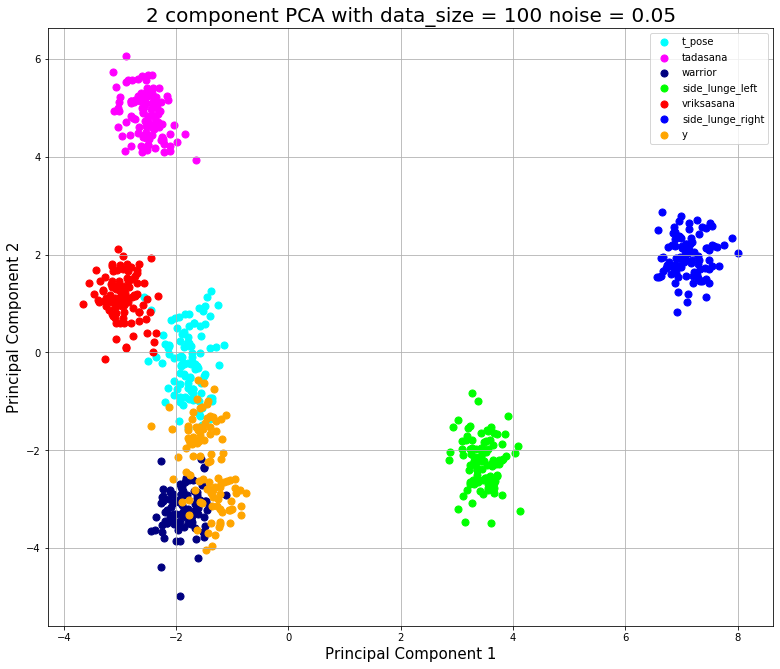

In [6]:
fig = plt.figure(figsize=(13,11))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(str('2 component PCA with data_size = {} noise = {}'.format(data_size, noise)), fontsize = 20)
targets = class_names
colors = ['aqua', 'magenta', 'navy', 'lime', 'red', 'blue', 'orange', 'yellow', 'maroon', 'coral','plum']

for target, color in zip(targets,colors):
    indicesToKeep = final_df['Class'] == target
    ax.scatter(final_df.loc[indicesToKeep, 0],
               final_df.loc[indicesToKeep, 1],
               c = color, s = 50)
    
ax.legend(targets)
ax.grid()

## Encode the labels so we can feed it into the SVM.

In [7]:
def encode_labels(labels):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    name_map = {key:val for key,val in zip(integer_encoded,labels)}
    return np.array(integer_encoded), name_map

labels_encoded, name_map = encode_labels(l_aug)

## Get the ideal poses for each class.

In [8]:
def get_ideal_pose(features, labels, name_map):
    ideal_poses = {}
    for lab, name in name_map.items():
        feature_list = np.array([feats for i, feats in enumerate(features) if labels[i]==lab])
        ideal_poses[name] = np.average(feature_list, axis=0)
        
    return ideal_poses

ideal_poses = get_ideal_pose(f_aug, labels_encoded, name_map)


## Plot the polar coordinates for the features of each class

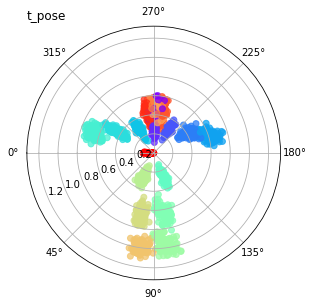

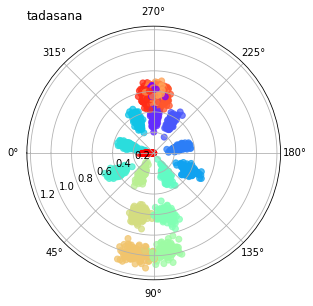

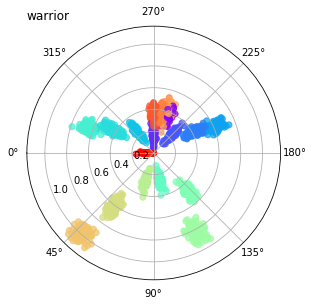

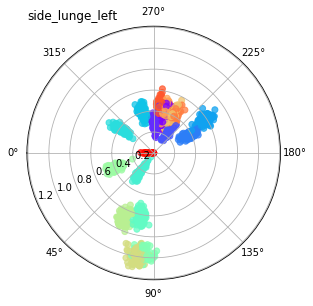

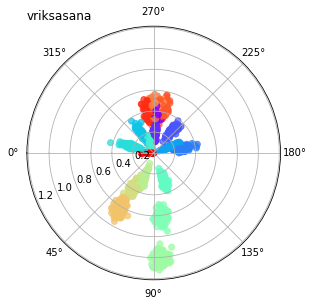

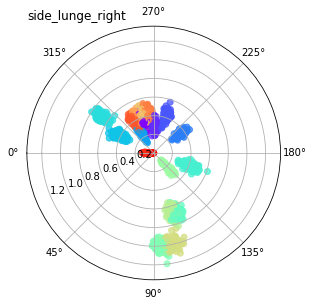

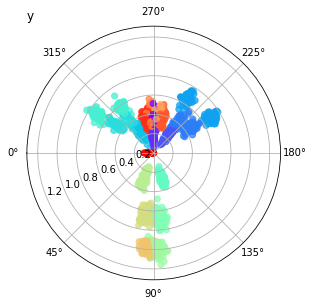

In [9]:
import matplotlib.cm as cm

for lab,name in name_map.items():
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(121 + lab%2, projection='polar')
    ax.set_theta_zero_location("W")
    plt.title(str(name_map[lab]),loc='left')
    feature_list = np.array([feats for i, feats in enumerate(f_aug) if labels_encoded[i]==lab])
    for feat in feature_list:
        colors = cm.rainbow(np.linspace(0, 1, len(feat[:,0])))
        c = ax.scatter(feat[:,1],feat[:,0],cmap='hsv',alpha=0.75,c=colors)
        

## Time to train the SVM!
Take the augmented data/labels that we've generated, flatten the features vector, then pass into the SVM function for training.
This will create */assets/classifier.pkl* which can be loaded at any time for prediction.

In [10]:
features_flat = flatten_dataset(f_aug)
print('augmented features shape: ', str(f_aug.shape))
print('flattened features shape: ', str(features_flat.shape))
print('encoded labels shape: ', str(labels_encoded.shape))
classifier, svm = train_svm_classifier(features_flat, labels_encoded,'assets/classifier.pkl')

augmented features shape:  (700, 19, 2)
flattened features shape:  (700, 38)
encoded labels shape:  (700,)
x_train shape: (560, 38)	y_train shape: (560,)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.



Confusion Matrix:
[[23  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0]
 [ 0  0 26  0  0  0  0]
 [ 0  0  0 18  0  0  0]
 [ 0  0  0  0 21  0  0]
 [ 0  0  0  0  0 21  0]
 [ 0  0  0  0  0  0 20]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        21
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        20

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.8s finished
/Users/djalova/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Test the SVM using the data in the assets/images/test folder

The prediction is y with confidence 38.872946225929766 %
The real pose is  malasana_1


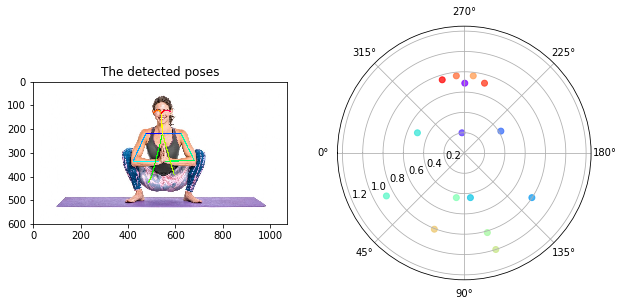

The prediction is y with confidence 94.15878092343016 %
The real pose is  test_m


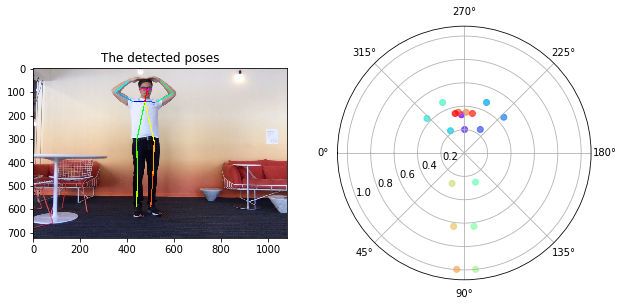

The prediction is tadasana with confidence 95.43448666313493 %
The real pose is  tada_photo


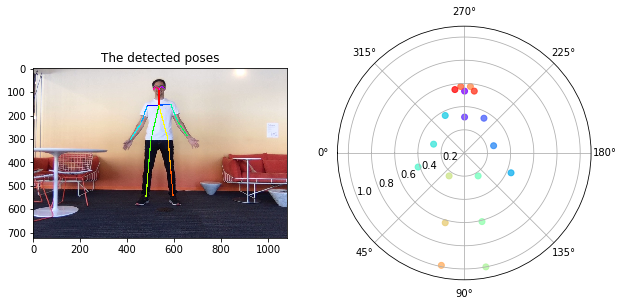

The prediction is side_lunge_right with confidence 78.92580225892416 %
The real pose is  war0


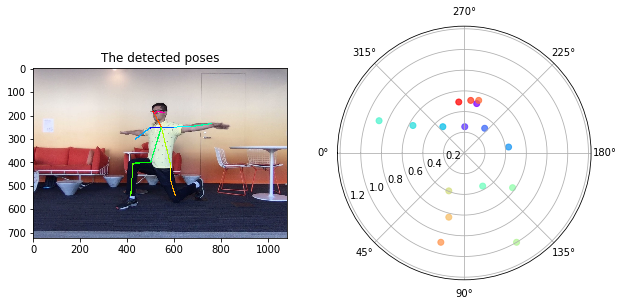

The prediction is y with confidence 96.70276592229347 %
The real pose is  test_y


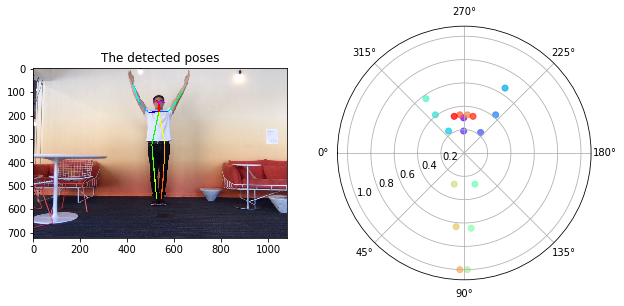

The prediction is warrior with confidence 98.40522298482718 %
The real pose is  war5


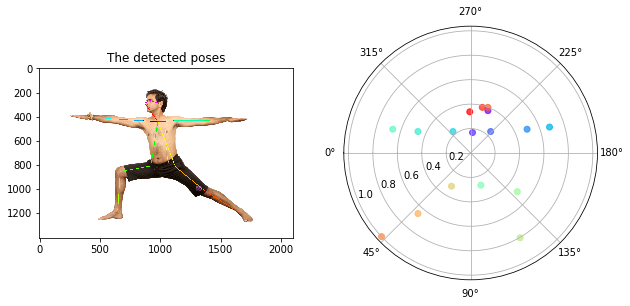

The prediction is t_pose with confidence 98.93022093980962 %
The real pose is  t4


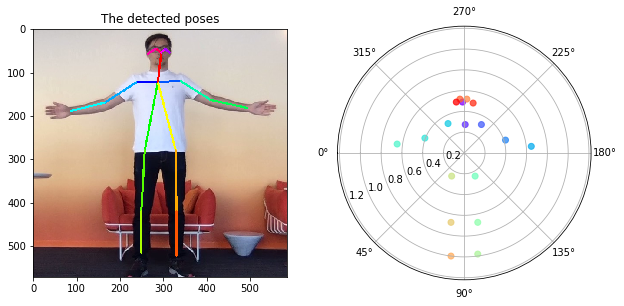

The prediction is t_pose with confidence 98.83273509058483 %
The real pose is  t5


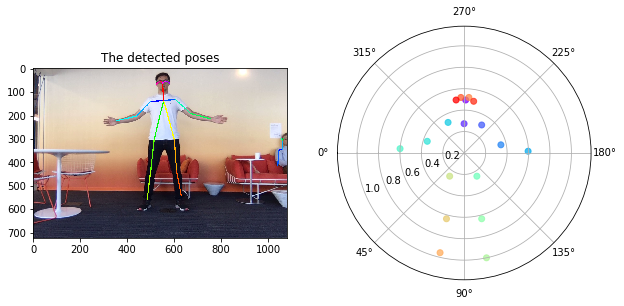

The prediction is tadasana with confidence 96.28378144447491 %
The real pose is  tada_test


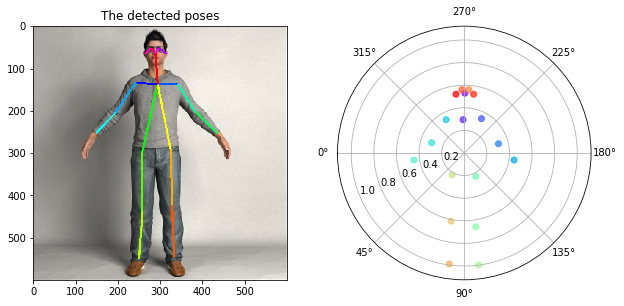

The prediction is y with confidence 38.884744841884725 %
The real pose is  chair2


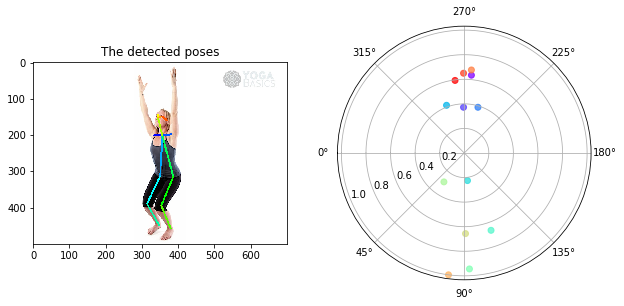

The prediction is y with confidence 38.08844631223957 %
The real pose is  jump_2


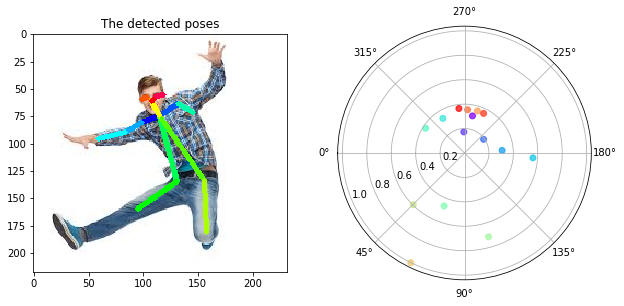

The prediction is side_lunge_left with confidence 61.744366304845364 %
The real pose is  vrik2


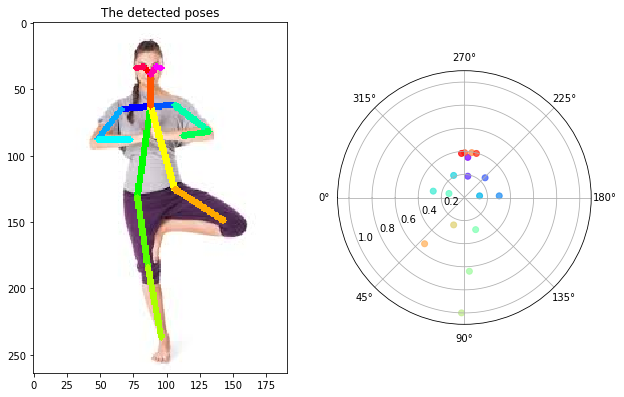

The prediction is t_pose with confidence 98.67805591078648 %
The real pose is  real_t_pose


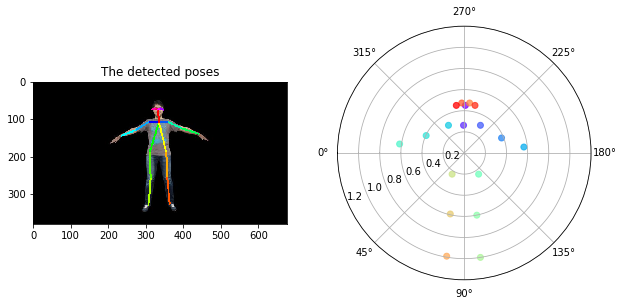

The prediction is y with confidence 38.545306577486016 %
The real pose is  jump_3


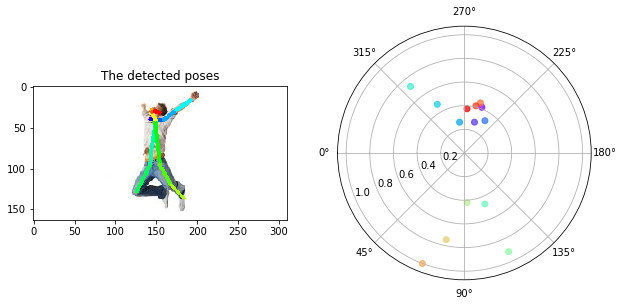

The prediction is y with confidence 38.886631181413115 %
The real pose is  mala_2


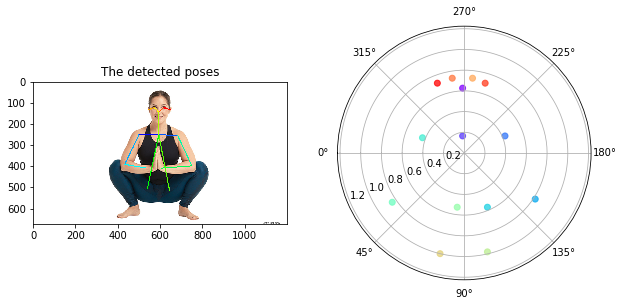

The prediction is y with confidence 39.62915403095292 %
The real pose is  vrik4


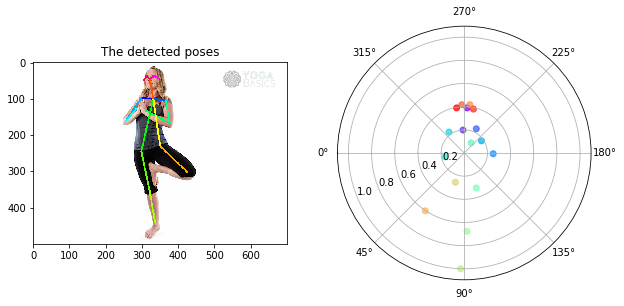

The prediction is y with confidence 38.88666814925302 %
The real pose is  e3


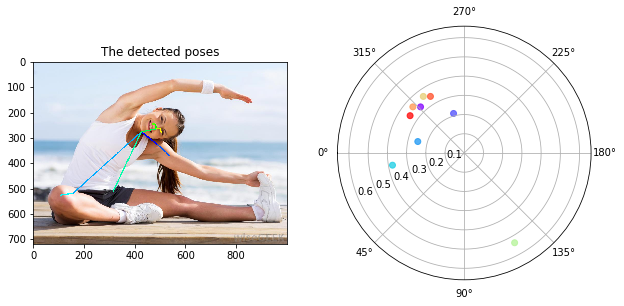

The prediction is y with confidence 38.886155866933386 %
The real pose is  stretchy


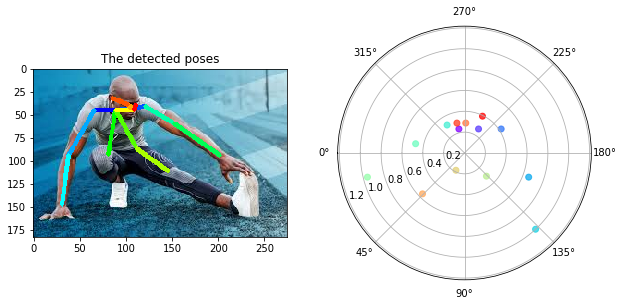

The prediction is y with confidence 35.39712849681857 %
The real pose is  jump_test


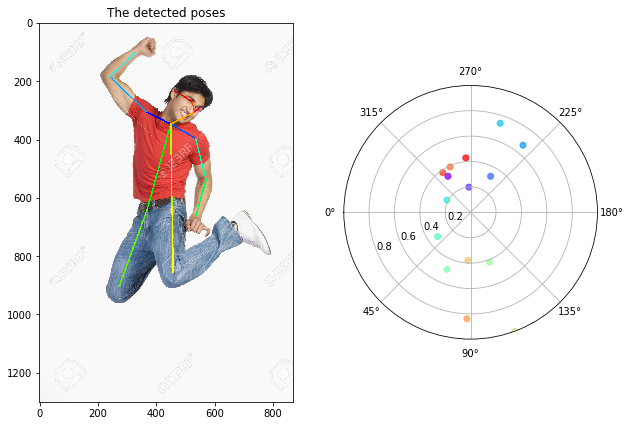

The prediction is warrior with confidence 55.31375750944842 %
The real pose is  war5


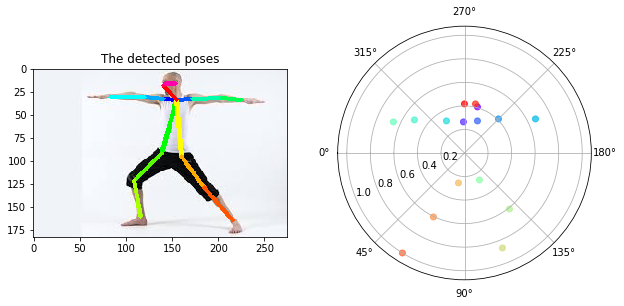

The prediction is vriksasana with confidence 50.059015535881436 %
The real pose is  jump4


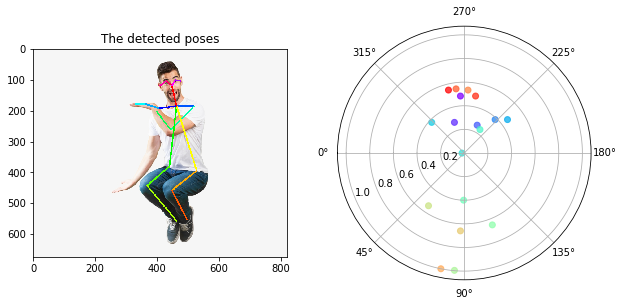

IndexError: list index out of range

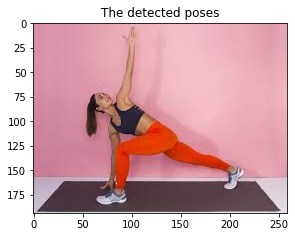

In [11]:
for img in os.listdir(str(os.getcwd())+'/assets/images/test'):
    fig = plt.figure(figsize=(10,15))
    # visualize the pose
    plt.subplot(1,2,1)
    
    preds, frame = get_pose_from_file(img,'test')
    bgr = np.array(cv2.imread('./assets/images/test/'+img))
    pose_img = bgr[..., ::-1]
    draw_pose(preds, bgr)
    plt.imshow(pose_img)
    plt.title("The detected poses")
    
    # make predictions
    body_parts = preds['predictions'][0]['body_parts']
    coordinates = np.array([[d['x'], d['y']] for d in body_parts], dtype=np.float32)
    pose = np.array(convert_pose(coordinates, cartesian=False))
    x = flatten_dataset(np.expand_dims(fill_empty_vector(np.squeeze(pose)), axis=0))
    p = classifier.predict(x)
    prediction = name_map[p[0]]
    confidence = classifier.predict_proba(x)
    print('The prediction is {} with confidence {} %'.format(prediction, 100 * confidence[0][p[0]]))
    print('The real pose is ', img.split('.')[0])
    
    # visualize the polar plot
    ax = plt.subplot(1, 2, 2, projection='polar')
    ax.set_theta_zero_location("W")
    colors = cm.rainbow(np.linspace(0, 1, len(pose[:,0])))
    c = plt.scatter(pose[:, 1], pose[:, 0], cmap='hsv', alpha=0.75, c=colors)
    plt.show()